In [8]:
from utils_convergence import count_independent_occurrences, convergent_evo_dataframe, mean_rate_on_tree 
from augur.utils import json_to_tree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import numpy as np
import pandas as pd
import requests
import random
import re

## Figure 4: A 3-amino acid deletion in Nsp6 displays convergent evolution and occurs in successful clades

##### The relative success of clades containing a given convergently-evolved mutation may fluctuate over time in either due to real biological and epidemiological reasons or stochastically. Mutations that are consistently present in successful clades (over many time points) likely have a real function in driving adaptive evolution.

#### This notebook completes the analyses for Figure 4C

At a given date, find which mutations appear on internal branches of the phylogeny at least 4 times and record the average growth rates of clades with these mutations, as well as whether this average exceeds the tree-wide average growth rate 

In [2]:
def top_mutations_and_rates(date, mutation_type='aa',  min_occurrences = 4):
    
    #Download tree json for specified date
    tree_url = f"https://nextstrain-blab.s3.amazonaws.com/ncov_adaptive-evolution_{date}.json"
    tree_json = requests.get(tree_url).json()
    #Put tree in Bio.Phylo format
    tree = json_to_tree(tree_json)
    
    #find all mutations that occur on internal branchs and how many times
    all_mutations_unique, independent_occurrences_all_mutations = count_independent_occurrences(tree)    
    
    # make a dataframe with information about number of occurrences and growth rates of each mutation
    df = convergent_evo_dataframe(tree, all_mutations_unique, independent_occurrences_all_mutations)
    
    # take a subset of the data, only including mutations that appear `min_occurrences` of more times
    df_zoom = df.loc[df['independent_occurrences']>=min_occurrences].reset_index()
    
    # find overall average growth rate at this date
    mean_growth_rate = mean_rate_on_tree(tree)
    df_zoom['overall_avg_growth'] = mean_growth_rate
    
    # create a column to say whether the average growth rate of clades where 
    # this mutation occurs is higher than the tree-wide average growth rate (at this time point)
    df_zoom['greater_than_average'] = np.where(df_zoom['avg_growth']>df_zoom['overall_avg_growth'], 1.0, 0.5)
    df_zoom['greater_than_zero'] =np.where(df_zoom['avg_growth']>0.0, 1.0, 0.5)
    
    # create a column for the date of the tree
    df_zoom['date'] = date

    return df_zoom

Create a dataframe containing the information about convergently-evolved mutations collected by the function above, for multiple dates

In [3]:
def compile_multiple_dates(dates):
    
    all_dates_info = []
    
    for date in dates:
        all_dates_info.append(top_mutations_and_rates(date))
        
    df = pd.concat(all_dates_info)
    
    return df

Plot growth rates of convergently-evolved mutations over time

In [28]:
def fig4c_plot_dates_exceeding_avg_growth(dates, filename=False):
    
    df = compile_multiple_dates(dates)
    
    df = df[['mutation', 'date', 'greater_than_average']].copy()
#     df['mutation_label'] = df['mutation'].str.split(':').str[0]+':'+df['mutation'].str.split(':').str[1].str[1:]
#     df['mutation_label'] = np.where(df['mutation']=='ORF1a:3675-3677del', 
#                                     'ORF1a:3675-3677del', 
#                                     df['mutation_label'])

    df = df.pivot(index='mutation', columns='date', values='greater_than_average').fillna(0.0)
    df['rank'] = df.sum(axis=1)
    
    # reorder dataframe to rank consistent mutations highest
    ranks = list(df.nlargest(len(df), keep='all', columns='rank').index)
    df.index = pd.CategoricalIndex(df.index, categories= ranks)
    df.sort_index(level=0, inplace=True)
    
    df = df.drop('rank', axis=1)
    
    myColors = ('white', '#F9EAC0', '#ebbc2d')

    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

    fig, ax = plt.subplots(figsize=(5,10))
    plt.tight_layout()
    sns.set_style('white')
    
    ax = sns.heatmap(df, cmap=cmap, cbar=False)

    ax.set_ylabel('', fontsize=16)
    ax.set_xlabel('', fontsize=16)
    
    for i in range(len(df) + 1):
        ax.axhline(i, color='white', lw=24)

    low_growth_rate = mpatches.Patch(color='#F9EAC0', label='convergent evolution only')
    high_growth_rate = mpatches.Patch(color='#ebbc2d', label='convergent evolution and high growth rate')

    plt.legend(handles=[low_growth_rate, high_growth_rate], 
               bbox_to_anchor=(0.55, 1.05), loc='upper center')
    
    ax.tick_params(left=False, bottom=False)
    
    plt.figtext(-0.15, 1.0, 'C', fontsize=24, fontweight='bold')
    if filename:
        fig.savefig(filename, dpi=300, bbox_inches='tight')



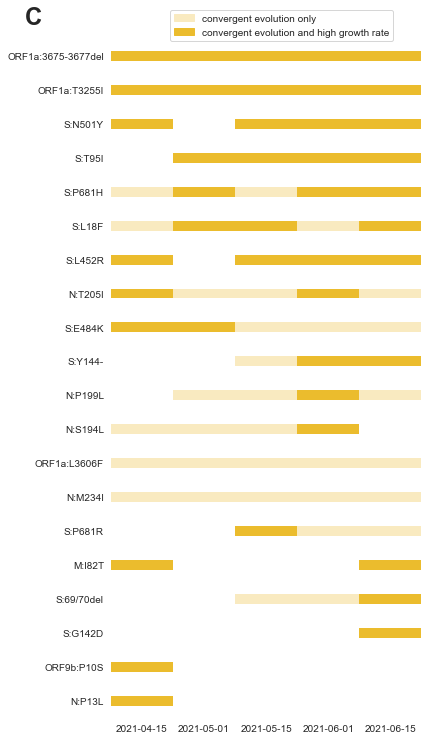

In [29]:
fig4c_plot_dates_exceeding_avg_growth(['2021-04-15', '2021-05-01', '2021-05-15', 
                                       '2021-06-01', '2021-06-15'], filename='plots/fig4c_20210515.png')